# Muestreo Centros Digitales

### Cambios en esta versión
* Agregar Restricciones
 * No más de 18 aps del mismo Beam satelital en la misma hora
 * Asegurar que exista en cada hora un ap de diferentes franjas de banda
* Nueva versión de la lógica de asignación de muestras

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Parámetro para definir el medio de carga de datos

In [4]:
formas_de_ingreso=['db','archivos']
modoIngresoInformacion=formas_de_ingreso[1] #cambia a 1 si se usan archivos

## Lectura Bases de datos

In [5]:
if modoIngresoInformacion== 'db':
    ## Llamado funcion para consulta y parametros
    #from get_data_from_db import *
    #registros, aps_operativos, num_aps, num_muestras_hora=GetDataFromDB()
    #Data=pd.DataFrame.from_records(registros)
    #Carga Archivos Prueba
    Data = pd.read_csv(f'query-Muestras-SQL.csv', sep=';')
    num_aps=Data['ID'].nunique()
    num_muestras_hora=int(num_aps*0.1)+1
    print(num_aps,num_muestras_hora)

## Lectura Archivos
###### Codigo para realizar el proceso con lectura de archivos

In [6]:
if modoIngresoInformacion== 'archivos':
    #DataAnterior = pd.read_csv(f'DATA_ACUMULADA.csv', sep=';')
    DataAnterior = pd.read_csv(f'Ejecuciones mensuales - Reporte plano_old.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataMesActual = pd.read_csv(f'Ejecuciones mensuales - Reporte plano.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataAnteriorB2 =pd.read_csv(f'Analitica Pruebas Adicionales TEST_STDB_old.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataMesActualB2 =pd.read_csv(f'Analitica Pruebas Adicionales TEST_STDB.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    
    DataMesActual['BASE']='principal'
    DataAnterior['BASE']='principal'
    DataMesActualB2['BASE']='adicional'
    DataAnteriorB2['BASE']='adicional'
    
    centrosA1=pd.read_csv(f'CLASE_CENTROS.csv',sep=";")
    centrosA1=centrosA1[centrosA1['TIPO']=='1A']
    centrosA1.drop(columns=['ID'], inplace=True)
    #DataAnterior['FECHA']=pd.to_datetime(DataAnterior['FECHA'],dayfirst=True)#valores por defecto    
    Data=DataAnterior.append(DataMesActual)
    Data=Data.append(DataAnteriorB2)
    Data=Data.append(DataMesActualB2)
    
    columnasSeleccionadas=[ 'ID Beneficiario','Perfil Ancho de banda', 'Kbps de Subida','Kbps de Bajada','Fecha de la prueba','Hora de la prueba','Condición Encontrada',
                           'Velocidad Efectiva (Download)','Velocidad Efectiva (Upload)','Cumple Ancho de Banda', 'Cumple BW de Bajada','Cumple BW de Subida','BASE']
    Data=Data[columnasSeleccionadas]
    Data.columns=["ID","BANDA","SUBIDA_LIM","BAJADA_LIM","FECHA","HORA","CONDICION","VELOCIDAD_BAJADA","VELOCIDAD_SUBIDA","CUMPLE_BANDA","CUMPLE_SUBIDA","CUMPLE_BAJADA",'BASE']
    #Data=DataAnterior.append(DataMesActual)
    Data=Data.merge(centrosA1[['ID BENEFICIARIO','ESTADO']], left_on='ID', right_on='ID BENEFICIARIO', how='inner')
    Data.drop(columns=['ID BENEFICIARIO','ESTADO'],inplace=True)
    #parametros de los archivos    
    num_aps=Data['ID'].nunique()
    num_muestras_hora=int(num_aps*0.1)+1

In [7]:
num_horas=15

### Leer Archivo Festivos

In [8]:
ubicacionArchivoFestivos="F:/Workflow/Projects\MinTIC_SpeedTest/ProcessScripts/"
ubicacionArchivoFestivos="" #en caso de no ejecutar en el servidor
diasFestivos=pd.read_csv(f'{ubicacionArchivoFestivos}initialize-general-list-holidays.csv',sep=";")
diasFestivos['fecha']=pd.to_datetime(diasFestivos[['YEAR', 'MONTH', 'DAY']])

### Preprocesamiento

In [9]:
Data['FECHA']=pd.to_datetime(Data['FECHA']).dt.date
Data['FECHA']=pd.to_datetime(Data['FECHA'])
maxFecha=Data['FECHA'].max()
minFecha=maxFecha + datetime.timedelta(days=-14)
minFechaFDS=maxFecha + datetime.timedelta(days=-28)

In [10]:
Data['DIA_S']=Data['FECHA'].dt.dayofweek
Data['FILTRO']=Data['DIA_S'].isin([5,6])
Data['FILTRO']=np.where(Data['DIA_S'].isin([5,6]) , 'fds','hab')
Data['FILTRO']=np.where(Data['FECHA'].isin(diasFestivos['fecha']),'fds',Data['FILTRO'])

In [11]:
Data.drop_duplicates(subset=["ID","BANDA","SUBIDA_LIM","BAJADA_LIM","FECHA","HORA","CONDICION","VELOCIDAD_BAJADA","VELOCIDAD_SUBIDA","CUMPLE_BANDA","CUMPLE_SUBIDA","CUMPLE_BAJADA"],keep='first', inplace=True)

In [12]:
Data=Data[(Data['HORA']>=6)&(Data['HORA']<=20)]

In [13]:
DataTotal=Data.copy()

In [14]:
Data=Data[(Data['FECHA']>=minFecha)&(Data['FECHA']<maxFecha)]

##  Resumenes validación

In [15]:
def pieChart(col):
    A = col.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.0f %%", colors=['dodgerblue','red'])
    plt.axis("equal")
    plt.show()    

In [16]:
## TORTA 1
Data[Data['BASE']=='principal']['CONDICION'].value_counts()

E    13316
F     3454
Name: CONDICION, dtype: int64

In [17]:
Data[Data['BASE']=='principal']['CONDICION'].value_counts()/len(Data[Data['BASE']=='principal'])

E    0.794037
F    0.205963
Name: CONDICION, dtype: float64

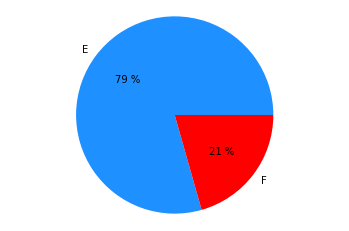

In [18]:
pieChart(Data[Data['BASE']=='principal']['CONDICION'])

In [19]:
DataExito=Data[Data['CONDICION']=='E']

In [20]:
## TORTA 2
DataExito[Data['BASE']=='principal']['CUMPLE_BANDA'].value_counts()

SI    10572
NO     2744
Name: CUMPLE_BANDA, dtype: int64

In [21]:
DataExito[Data['BASE']=='principal']['CUMPLE_BANDA'].value_counts()/len(DataExito)

SI    0.200641
NO    0.052077
Name: CUMPLE_BANDA, dtype: float64

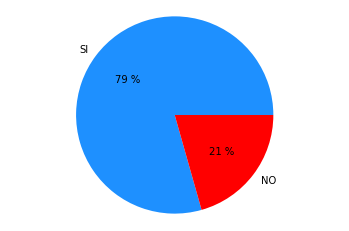

In [22]:
pieChart(DataExito[Data['BASE']=='principal']['CUMPLE_BANDA'])

In [23]:
DataExito[Data['BASE']=='principal']['CUMPLE_SUBIDA'].value_counts()/len(DataExito[Data['BASE']=='principal'])

SI    0.838165
NO    0.161835
Name: CUMPLE_SUBIDA, dtype: float64

In [24]:
DataExito[Data['BASE']=='principal']['CUMPLE_BAJADA'].value_counts()/len(DataExito[Data['BASE']=='principal'])

SI    0.920847
NO    0.079153
Name: CUMPLE_BAJADA, dtype: float64

In [25]:
#conteo centros con exito
DataExito[Data['BASE']=='principal']['ID'].nunique()

702

In [26]:
#conteo centrol críticos
num_aps-DataExito[Data['BASE']=='principal']['ID'].nunique()

56

In [27]:
###  GRAFICO

In [28]:
res_hora_cumple_Banda=pd.crosstab(index=DataExito['HORA'],
            columns=DataExito['CUMPLE_BANDA'], margins=True)

In [29]:
res_hora_cumple_Banda['NO']=res_hora_cumple_Banda['NO']/res_hora_cumple_Banda['All']
res_hora_cumple_Banda['SI']=res_hora_cumple_Banda['SI']/res_hora_cumple_Banda['All']

In [30]:
pd.crosstab(index=DataExito['HORA'],
            columns=DataExito['CUMPLE_BANDA'], margins=True, normalize='index')

CUMPLE_BANDA,NO,SI
HORA,,
6,0.125182,0.874818
7,0.156656,0.843344
8,0.158792,0.841208
9,0.186060,0.813940
10,0.180776,0.819224
11,0.187585,0.812415
12,0.193858,0.806142
13,0.205305,0.794695
14,0.206446,0.793554


#### Gráfico

In [31]:
res_grafico=pd.pivot_table(Data[Data['BASE']=='principal'].groupby(['BANDA','HORA','CUMPLE_BANDA'])['ID'].count().reset_index(), index=['BANDA','HORA'],columns=['CUMPLE_BANDA'], values='ID', aggfunc=np.sum, fill_value=0)

In [32]:
res_grafico['TOTAL']=res_grafico.sum(axis=1)

In [33]:
res_grafico['PORCF']=res_grafico['SI']/res_grafico['TOTAL']

In [34]:
res_grafico.reset_index(inplace=True)

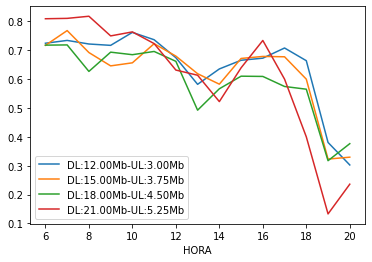

In [35]:
fig, ax = plt.subplots()
for label, grp in res_grafico.groupby('BANDA'):
    grp.plot(x = 'HORA', y = 'PORCF',ax = ax, label = label)

In [36]:
res_grafico.to_csv('grafica.csv')

In [37]:
def quantiles_adaptados(x):
    conteo=x.count()
    if conteo<=5:
        return x.quantile(0.5)
    elif conteo<=10:
        return x.quantile(0.2)
    else:
        return x.quantile(0.1)

### Archivos de Resumen

In [38]:
today = date.today()
D=today.day
M=today.month
Y=today.year

# Habiles

In [39]:
Data_Habil= Data[(Data['BASE']=='principal')&(Data['FILTRO']=='hab')].groupby(['ID','HORA']).agg(
                CONTEO=('ID','count'),
                SUBIDA=('VELOCIDAD_SUBIDA', quantiles_adaptados),
                BAJADA=('VELOCIDAD_BAJADA', quantiles_adaptados)
            )

In [40]:
Data_Habil.reset_index(inplace=True)
BANDA=Data[['ID','BANDA','SUBIDA_LIM','BAJADA_LIM']].drop_duplicates(subset='ID',keep='last')
Data_Habil=Data_Habil.merge(BANDA,left_on='ID',right_on='ID', how='left')
Data_Habil.rename(columns={'BAJADA_LIM':'BAJA','SUBIDA_LIM':'SUBE','BAJADA':'BAJA_R','SUBIDA':'SUBE_R'}, inplace=True)
Data_Habil=Data_Habil[['ID','BANDA','HORA','BAJA','SUBE','BAJA_R','SUBE_R']]

In [41]:
Data_Habil['CUMPLE_BAJA']=np.where(Data_Habil['BAJA_R']>=Data_Habil['BAJA'],'SI','NO')
Data_Habil['CUMPLE_SUBE']=np.where(Data_Habil['SUBE_R']>=Data_Habil['SUBE'],'SI','NO')
Data_Habil['CUMPLE']=np.where( (Data_Habil['CUMPLE_BAJA']=='SI') & (Data_Habil['CUMPLE_SUBE']=='SI'),'SI','NO')
Data_Habil['PORC_BAJADA']=Data_Habil['BAJA_R']/Data_Habil['BAJA']
Data_Habil['PORC_SUBE']=Data_Habil['SUBE_R']/Data_Habil['SUBE']
Data_Habil['CERCANO_BAJA']=np.where(Data_Habil['PORC_BAJADA']>1, 'CUMPLE', np.where(Data_Habil['PORC_BAJADA']>0.9,'SI','NO'))
Data_Habil['CERCANO_SUBE']=np.where(Data_Habil['PORC_SUBE']>1, 'CUMPLE', np.where(Data_Habil['PORC_SUBE']>0.9,'SI','NO'))
Data_Habil['CERCANO']=np.where( (Data_Habil['CERCANO_BAJA']=='CUMPLE') & (Data_Habil['CERCANO_SUBE']=='CUMPLE'),'CUMPLE',
                                 np.where((Data_Habil['CERCANO_BAJA']=='SI') & (Data_Habil['CERCANO_SUBE']=='SI'),'AMBOS',
                                         np.where((Data_Habil['CERCANO_BAJA']=='CUMPLE') & (Data_Habil['CERCANO_SUBE']=='SI'),'SUBE',
                                                 np.where((Data_Habil['CERCANO_BAJA']=='SI') & (Data_Habil['CERCANO_SUBE']=='CUMPLE'),'BAJA','NO'))))

In [42]:
Data_Habil_Res=Data_Habil.copy()
Data_Habil_Res['TIPO2']=np.where(Data_Habil_Res['CERCANO']=="NO",'NO','SI')
Data_Habil_Res=pd.pivot_table(Data_Habil_Res[['ID','BANDA','CUMPLE']], index=['ID','BANDA'], columns=['CUMPLE'], aggfunc=len, fill_value=0)
Data_Habil_Res['PORC']=Data_Habil_Res['NO']/(Data_Habil_Res['NO']+Data_Habil_Res['SI'])
Data_Habil_Res['TIPO']= np.where(Data_Habil_Res['PORC']==1,'CRITICO',np.where(Data_Habil_Res['PORC']==0,'BUENO','REGULAR'))

In [43]:
## DIAPOSITIVA 4
Data_Habil.head(14).style.set_table_styles([{
    'selector':'th', 'props':[('background-color','#c00000'),('color','white')]
}])

,ID,BANDA,HORA,BAJA,SUBE,BAJA_R,SUBE_R,CUMPLE_BAJA,CUMPLE_SUBE,CUMPLE,PORC_BAJADA,PORC_SUBE,CERCANO_BAJA,CERCANO_SUBE,CERCANO
0,10835,DL:18.00Mb-UL:4.50Mb,14,18000,4500,15666.030000,3261.530000,NO,NO,NO,0.870335,0.724784,NO,NO,NO
1,10835,DL:18.00Mb-UL:4.50Mb,15,18000,4500,15989.330000,3578.170000,NO,NO,NO,0.888296,0.795149,NO,NO,NO
2,10835,DL:18.00Mb-UL:4.50Mb,18,18000,4500,16262.820000,3636.405000,NO,NO,NO,0.903490,0.808090,SI,NO,NO
3,10835,DL:18.00Mb-UL:4.50Mb,19,18000,4500,15991.040000,3705.500000,NO,NO,NO,0.888391,0.823444,NO,NO,NO
4,10835,DL:18.00Mb-UL:4.50Mb,20,18000,4500,15867.415000,2995.550000,NO,NO,NO,0.881523,0.665678,NO,NO,NO
5,11113,DL:21.00Mb-UL:5.25Mb,8,21000,5250,25099.580000,10561.580000,SI,SI,SI,1.195218,2.011730,CUMPLE,CUMPLE,CUMPLE
6,11113,DL:21.00Mb-UL:5.25Mb,9,21000,5250,24782.000000,10626.300000,SI,SI,SI,1.180095,2.024057,CUMPLE,CUMPLE,CUMPLE
7,11113,DL:21.00Mb-UL:5.25Mb,10,21000,5250,25128.970000,10615.970000,SI,SI,SI,1.196618,2.022090,CUMPLE,CUMPLE,CUMPLE
8,11113,DL:21.00Mb-UL:5.25Mb,16,21000,5250,25202.760000,10679.380000,SI,SI,SI,1.200131,2.034168,CUMPLE,CUMPLE,CUMPLE
9,11113,DL:21.00Mb-UL:5.25Mb,18,21000,5250,25102.280000,10664.880000,SI,SI,SI,1.195347,2.031406,CUMPLE,CUMPLE,CUMPLE


In [44]:
### Guardar Achivos
Data_Habil.to_csv('RESUMEN_CENTROS_HORA_'+str(Y*10000+M*100+D)+'_HABIL.csv',sep=';', index=False)
Data_Habil_Res.to_csv('RESUMEN_CENTROS_'+str(Y*10000+M*100+D)+'_HABIL.csv',sep=';', index=False)

### FDS

In [45]:
Data_fds= DataTotal[(DataTotal['BASE']=='principal')&(DataTotal['FILTRO']=='fds')&(DataTotal['FECHA']>=minFechaFDS)&(DataTotal['FECHA']<maxFecha)].groupby(['ID','HORA']).agg(
                CONTEO=('ID','count'),
                SUBIDA=('VELOCIDAD_SUBIDA', quantiles_adaptados),
                BAJADA=('VELOCIDAD_BAJADA', quantiles_adaptados)
            )

In [46]:
Data_fds.reset_index(inplace=True)
BANDA=Data[['ID','BANDA','SUBIDA_LIM','BAJADA_LIM']].drop_duplicates(subset='ID',keep='last')
Data_fds=Data_fds.merge(BANDA,left_on='ID',right_on='ID', how='left')
Data_fds.rename(columns={'BAJADA_LIM':'BAJA','SUBIDA_LIM':'SUBE','BAJADA':'BAJA_R','SUBIDA':'SUBE_R'}, inplace=True)
Data_fds=Data_fds[['ID','BANDA','HORA','BAJA','SUBE','BAJA_R','SUBE_R']]

In [47]:
Data_fds['CUMPLE_BAJA']=np.where(Data_fds['BAJA_R']>=Data_fds['BAJA'],'SI','NO')
Data_fds['CUMPLE_SUBE']=np.where(Data_fds['SUBE_R']>=Data_fds['SUBE'],'SI','NO')
Data_fds['CUMPLE']=np.where( (Data_fds['CUMPLE_BAJA']=='SI') & (Data_fds['CUMPLE_SUBE']=='SI'),'SI','NO')
Data_fds['PORC_BAJADA']=Data_fds['BAJA_R']/Data_fds['BAJA']
Data_fds['PORC_SUBE']=Data_fds['SUBE_R']/Data_fds['SUBE']
Data_fds['CERCANO_BAJA']=np.where(Data_fds['PORC_BAJADA']>1, 'CUMPLE', np.where(Data_fds['PORC_BAJADA']>0.9,'SI','NO'))
Data_fds['CERCANO_SUBE']=np.where(Data_fds['PORC_SUBE']>1, 'CUMPLE', np.where(Data_fds['PORC_SUBE']>0.9,'SI','NO'))
Data_fds['CERCANO']=np.where( (Data_fds['CERCANO_BAJA']=='CUMPLE') & (Data_fds['CERCANO_SUBE']=='CUMPLE'),'CUMPLE',
                                 np.where((Data_fds['CERCANO_BAJA']=='SI') & (Data_fds['CERCANO_SUBE']=='SI'),'AMBOS',
                                         np.where((Data_fds['CERCANO_BAJA']=='CUMPLE') & (Data_fds['CERCANO_SUBE']=='SI'),'SUBE',
                                                 np.where((Data_fds['CERCANO_BAJA']=='SI') & (Data_fds['CERCANO_SUBE']=='CUMPLE'),'BAJA','NO'))))

In [48]:
Data_fds_Res=Data_fds.copy()
Data_fds_Res['TIPO2']=np.where(Data_fds_Res['CERCANO']=="NO",'NO','SI')
Data_fds_Res=pd.pivot_table(Data_fds_Res[['ID','BANDA','CUMPLE']], index=['ID','BANDA'], columns=['CUMPLE'], aggfunc=len, fill_value=0)
Data_fds_Res['PORC']=Data_fds_Res['NO']/(Data_fds_Res['NO']+Data_fds_Res['SI'])
Data_fds_Res['TIPO']= np.where(Data_fds_Res['PORC']==1,'CRITICO',np.where(Data_fds_Res['PORC']==0,'BUENO','REGULAR'))

In [49]:
Data_fds.to_csv('RESUMEN_CENTROS_HORA_'+str(Y*10000+M*100+D)+'_FDS.csv',sep=';',index=False)
Data_fds_Res.to_csv('RESUMEN_CENTROS_'+str(Y*10000+M*100+D)+'_FDS.csv',sep=';',index=False)

# Maestro Aps

In [50]:
maestro_Aps=Data[['ID','BANDA']].drop_duplicates()

#  NUEVA PROPUESTA

### Habiles

In [51]:
DataExito_base=DataExito.copy()

In [52]:
DataExito= DataExito[DataExito['FILTRO']=='hab']

## Procesamiento

In [53]:
DataExito['IND']=((DataExito['VELOCIDAD_SUBIDA']-DataExito['SUBIDA_LIM'])+(DataExito['VELOCIDAD_BAJADA']-DataExito['BAJADA_LIM']))/2
tabla_ind=DataExito.groupby(['ID','HORA'])[['IND']].median()
tabla_ind.reset_index(inplace=True)
tabla_freq=DataExito.groupby(['ID','HORA'])[['CONDICION']].count().reset_index()

In [54]:
tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
tablaBase.columns=['ID','HORA','IND','FREQ']
tablaBase.reset_index(inplace=True)
tabla_casos_cero=tablaBase.groupby('ID')[['IND']].max()
tabla_casos_cero=tabla_casos_cero[tabla_casos_cero['IND']==0]
casos_cero=tablaBase[tablaBase['ID'].isin(tabla_casos_cero.index)]
tablaBase=tablaBase[~tablaBase['ID'].isin(casos_cero['ID'].unique())]

### Distribución aps bajos

In [55]:
tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
tablaBase.reset_index(drop=True, inplace=True)
tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
casos_bajos=tabla_primera_opcion[tabla_primera_opcion['IND']<0]
muestra_bajas_hora=int(len(casos_bajos)/num_horas)+1

In [56]:
#casos_bajos=casos_bajos.sort_values('IND')[:(muestra_bajas_hora*num_horas)]
casos_bajos=casos_bajos.sort_values('IND')
casos_bajos.reset_index(inplace=True)
casos_bajos.reset_index(inplace=True)
#casos_bajos
#lograr la mayor distribución de hora posible
casos_bajos['franja']=np.where(casos_bajos['level_0']//num_horas%2==0,casos_bajos['level_0']%num_horas,(num_horas-1-casos_bajos['level_0']%num_horas))
casos_bajos['hora']=casos_bajos['franja']+6
tablaBase=tablaBase[~tablaBase['ID'].isin(casos_bajos['ID'].unique())]

In [57]:
num_muestras_hora=num_muestras_hora-muestra_bajas_hora
asignacionFinal=pd.DataFrame()

### asignacion principal

In [58]:
i=0
num_horas_sobre=1
while num_horas_sobre > 0:   
    #Reordenar la base
    tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
    tablaBase.reset_index(drop=True, inplace=True)
    tablaBase['index']=tablaBase.index
    
    tablaBase['dif']=tablaBase.groupby('ID')['IND'].diff(-1)
    tablaBase['index_N']=tablaBase.groupby('ID')['index'].shift(periods=-1)
    tablaBase['HORA_N']=tablaBase.groupby('ID')['HORA'].shift(periods=-1)
    tablaBase['IND_N']=tablaBase.groupby('ID')['IND'].shift(periods=-1)
    tablaBase['FREQ_N']=tablaBase.groupby('ID')['FREQ'].shift(periods=-1)

    tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
    tabla_primera_opcion.reset_index(inplace=True)
    
    tabla_ronda=tabla_primera_opcion
    
    resumen=tabla_ronda[['HORA']].value_counts().to_frame()
    resumen['DIF']=resumen[0]-num_muestras_hora
    
    horas_sobre=resumen[resumen['DIF']>0]           
    num_horas_sobre=len(horas_sobre)
    
    # guardar valores
    if num_horas_sobre>0:
        hora_aux=horas_sobre.index[0][0]
        dif_aux=horas_sobre.iloc[0]['DIF']
        tabla_ronda=tabla_ronda.sort_values('dif')
        saldo=tabla_ronda[tabla_ronda['HORA']==hora_aux][dif_aux:]        
        if i==0:
            asignacionFinal=saldo
        else: 
            asignacionFinal=asignacionFinal.append(saldo)            
        
        tablaBase=tablaBase[tablaBase['HORA']!=hora_aux]
        tablaBase=tablaBase[~tablaBase['ID'].isin(saldo['ID'])]    
        #tablaBase=tablaBase[~tablaBase['ID'].isin(tabla_cero['ID'])]
        i+=1
        
if i==0:
    asignacionFinal=tabla_ronda
else: 
    asignacionFinal=asignacionFinal.append(tabla_ronda)
    

#####  Matriz de posiciciones a llenar

In [59]:
num_muestras_hora=num_muestras_hora+muestra_bajas_hora

In [60]:
tabla_final=pd.DataFrame({'hora':list(range(6,20+1))},columns=['hora']+list(range(num_muestras_hora)))
tabla_final.set_index('hora',inplace=True)
tabla_final['pos']=0

### Asignar resultado anterior

In [61]:
for index, row in asignacionFinal.iterrows():    
    hora_aux=int(row['HORA'])
    pos=tabla_final.at[hora_aux,'pos']    
    tabla_final.at[hora_aux,pos]=int(row['ID'])    
    tabla_final.at[hora_aux,'pos']=tabla_final.at[hora_aux,'pos']+1

## Asignar casos bajos

In [62]:
for ind,row in casos_bajos.iterrows():
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
    sel_hora=row['hora']
    idx=int(row['ID'])
    pos=tabla_final.at[sel_hora,'pos']
    tabla_final.at[sel_hora,pos]=idx    
    tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1

## Agregar 100% F

In [63]:
## SE UNE CON LA PARTE INICIAL PUEDE SER EN ESTE PUNTO
APs_sin_Exito=Data[~Data['ID'].isin(DataExito['ID'].unique())]
APs_sin_Exito=list(APs_sin_Exito['ID'].unique())

In [64]:
for idx in APs_sin_Exito:
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
    sel_hora=t_aux.sample().index[0]
    pos=tabla_final.at[sel_hora,'pos']
    tabla_final.at[sel_hora,pos]=idx    
    tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1

### Asignar mejores casos

In [65]:
tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
#tablaBase.drop(columns=['NO','SI'], inplace=True)
tablaBase.columns=['ID','HORA','IND','FREQ']
tablaBase.reset_index(inplace=True)
mejores_hora=tablaBase[(tablaBase['IND']==1)&(tablaBase['FREQ']>=3)]
group_casos_mejora=mejores_hora.groupby('ID')

In [66]:
i=0
for g in group_casos_mejora.groups:
    i=i+1
    group = group_casos_mejora.get_group(g)
    val_ids=group['HORA'].values
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)&(t_aux.index.isin(val_ids))]
    t_aux= t_aux[~t_aux.isin([g]).any(axis=1)]
    
    for sel_hora in t_aux.index:
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=int(g)  
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
        

### Completar faltantes con mejores casos

In [67]:
tabla_ind_total=pd.pivot_table(DataExito[['ID','CUMPLE_BANDA','CONDICION']], index=['ID'], columns=['CUMPLE_BANDA'], aggfunc=len, fill_value=0)
tabla_ind_total.columns=tabla_ind_total.columns.droplevel()
tabla_ind_total.reset_index(inplace=True)
tabla_ind_total['ind']=tabla_ind_total['SI']/(tabla_ind_total['SI']+tabla_ind_total['NO'])
tabla_ind_total=tabla_ind_total.sort_values(['ind','SI'], ascending=False)
pos_mejores=0

In [68]:
while len(tabla_final[tabla_final['pos']<num_muestras_hora])>0:
    t_aux=tabla_final[tabla_final['pos']<num_muestras_hora]
    id_aux=tabla_ind_total['ID'].values[pos_mejores]
    t_aux= t_aux[~t_aux.isin([id_aux]).any(axis=1)]
    
    for sel_hora in t_aux.index:
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=int(id_aux)  
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
    pos_mejores=pos_mejores+1

In [69]:
## validar duplicados por hora
for hora,row in tabla_final.iterrows():    
    a_set = set(row)
    contains_duplicates = len(row) != len(a_set)
    print(hora,contains_duplicates)

6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


## Alistamiento de salida

In [70]:
tabla_ind_total['tipo']=np.where(tabla_ind_total['ind']==0, 'CRITICO', np.where(tabla_ind_total['ind']==1,'BUENO','REGULAR'))
tabla_final_un=tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID')
tabla_final_un=tabla_final_un.merge(tabla_ind_total, left_on='ID', right_on='ID', how='left')
tabla_final_un['tipo']=np.where(tabla_final_un['tipo'].isnull(),'CRITICO',tabla_final_un['tipo'])
tabla_final_un=tabla_final_un.merge(maestro_Aps, left_on='ID', right_on='ID', how='left')
archivo=tabla_final_un[['ID','BANDA','hora']]
archivo.columns=['ID','BANDA','HORA']
archivo=archivo.sort_values('HORA')

In [71]:
archivo.isnull().sum()

ID       0
BANDA    0
HORA     0
dtype: int64

In [72]:
archivo['BANDA'].value_counts()

DL:12.00Mb-UL:3.00Mb    547
DL:15.00Mb-UL:3.75Mb    355
DL:18.00Mb-UL:4.50Mb    169
DL:21.00Mb-UL:5.25Mb     69
Name: BANDA, dtype: int64

In [73]:
duplicateRowsDF = archivo[archivo.duplicated()]
duplicateRowsDF

,ID,BANDA,HORA


In [74]:
pd.crosstab(index=tabla_final_un['hora'],
            columns=tabla_final_un['tipo'], margins=True)

tipo,BUENO,CRITICO,REGULAR,All
hora,,,,
6,5,3,68,76
7,10,4,62,76
8,29,5,42,76
9,51,5,20,76
10,34,5,37,76
11,42,8,26,76
12,49,7,20,76
13,46,9,21,76
14,51,6,19,76


In [75]:
res_pres=pd.crosstab(index=tabla_final_un['hora'], columns=tabla_final_un['tipo'], margins=True)
res_pres['BUENO2']=res_pres['BUENO']+res_pres['REGULAR']
res_pres.drop(columns=['BUENO','REGULAR'],inplace=True)
res_pres=res_pres[['BUENO2','CRITICO','All']]
res_pres.columns=['BUENO','MALO','TOTAL']
#res_pres
res_pres.style.set_table_styles([{
    'selector':'th', 'props':[('background-color','#c00000'),('color','white')]
}])

,BUENO,MALO,TOTAL
hora,,,
6,73,3,76
7,72,4,76
8,71,5,76
9,71,5,76
10,71,5,76
11,68,8,76
12,69,7,76
13,67,9,76
14,70,6,76


In [76]:
###  MEDIR PERCENTIL 5 por hora y comparar casos

In [77]:
tabla_ind=DataExito.groupby(['ID','HORA'])[['IND']].median()
tabla_ind.reset_index(inplace=True)

In [78]:
tabla_final_un=tabla_final_un.merge(tabla_ind, left_on=['ID','hora'], right_on=['ID','HORA'],how='left')

In [79]:
tabla_final_un.groupby('hora')['IND'].quantile(0.05)

hora
6     1878.860750
7      875.576500
8      940.817500
9     1940.542750
10     653.229125
11     781.177500
12     520.592500
13    1804.457750
14    2400.300000
15    2152.442000
16     891.673750
17     644.555000
18    2604.107000
19    2121.095000
20    1898.866000
Name: IND, dtype: float64

In [80]:
archivo.to_csv('initialize-general-list-hab.csv',sep=';', index=False)

## FESTIVOS

In [81]:
DataExito=DataExito_base.copy()

In [82]:
DataExito= DataExito[DataExito['FILTRO']=='fds']

## Procesamiento

In [83]:
DataExito['IND']=((DataExito['VELOCIDAD_SUBIDA']-DataExito['SUBIDA_LIM'])+(DataExito['VELOCIDAD_BAJADA']-DataExito['BAJADA_LIM']))/2
tabla_ind=DataExito.groupby(['ID','HORA'])[['IND']].median()
tabla_ind.reset_index(inplace=True)
tabla_freq=DataExito.groupby(['ID','HORA'])[['CONDICION']].count().reset_index()

In [84]:
tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
tablaBase.columns=['ID','HORA','IND','FREQ']
tablaBase.reset_index(inplace=True)
tabla_casos_cero=tablaBase.groupby('ID')[['IND']].max()
tabla_casos_cero=tabla_casos_cero[tabla_casos_cero['IND']==0]
casos_cero=tablaBase[tablaBase['ID'].isin(tabla_casos_cero.index)]
tablaBase=tablaBase[~tablaBase['ID'].isin(casos_cero['ID'].unique())]

### Distribución aps bajos

In [85]:
tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
tablaBase.reset_index(drop=True, inplace=True)
tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
casos_bajos=tabla_primera_opcion[tabla_primera_opcion['IND']<0]
muestra_bajas_hora=int(len(casos_bajos)/num_horas)+1

In [86]:
#casos_bajos=casos_bajos.sort_values('IND')[:(muestra_bajas_hora*num_horas)]
casos_bajos=casos_bajos.sort_values('IND')
casos_bajos.reset_index(inplace=True)
casos_bajos.reset_index(inplace=True)
#casos_bajos
#lograr la mayor distribución de hora posible
casos_bajos['franja']=np.where(casos_bajos['level_0']//num_horas%2==0,casos_bajos['level_0']%num_horas,(num_horas-1-casos_bajos['level_0']%num_horas))
casos_bajos['hora']=casos_bajos['franja']+6
tablaBase=tablaBase[~tablaBase['ID'].isin(casos_bajos['ID'].unique())]

In [87]:
num_muestras_hora=num_muestras_hora-muestra_bajas_hora
asignacionFinal=pd.DataFrame()

### asignacion principal

In [88]:
i=0
num_horas_sobre=1
while num_horas_sobre > 0:   
    #Reordenar la base
    tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
    tablaBase.reset_index(drop=True, inplace=True)
    tablaBase['index']=tablaBase.index
    
    tablaBase['dif']=tablaBase.groupby('ID')['IND'].diff(-1)
    tablaBase['index_N']=tablaBase.groupby('ID')['index'].shift(periods=-1)
    tablaBase['HORA_N']=tablaBase.groupby('ID')['HORA'].shift(periods=-1)
    tablaBase['IND_N']=tablaBase.groupby('ID')['IND'].shift(periods=-1)
    tablaBase['FREQ_N']=tablaBase.groupby('ID')['FREQ'].shift(periods=-1)

    tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
    tabla_primera_opcion.reset_index(inplace=True)
    
    tabla_ronda=tabla_primera_opcion
    
    resumen=tabla_ronda[['HORA']].value_counts().to_frame()
    resumen['DIF']=resumen[0]-num_muestras_hora
    
    horas_sobre=resumen[resumen['DIF']>0]           
    num_horas_sobre=len(horas_sobre)
    
    # guardar valores
    if num_horas_sobre>0:
        hora_aux=horas_sobre.index[0][0]
        dif_aux=horas_sobre.iloc[0]['DIF']
        tabla_ronda=tabla_ronda.sort_values('dif')
        saldo=tabla_ronda[tabla_ronda['HORA']==hora_aux][dif_aux:]        
        if i==0:
            asignacionFinal=saldo
        else: 
            asignacionFinal=asignacionFinal.append(saldo)            
        
        tablaBase=tablaBase[tablaBase['HORA']!=hora_aux]
        tablaBase=tablaBase[~tablaBase['ID'].isin(saldo['ID'])]    
        #tablaBase=tablaBase[~tablaBase['ID'].isin(tabla_cero['ID'])]
        i+=1
        
if i==0:
    asignacionFinal=tabla_ronda
else: 
    asignacionFinal=asignacionFinal.append(tabla_ronda)
    

#####  Matriz de posiciciones a llenar

In [89]:
num_muestras_hora=num_muestras_hora+muestra_bajas_hora

In [90]:
tabla_final=pd.DataFrame({'hora':list(range(6,20+1))},columns=['hora']+list(range(num_muestras_hora)))
tabla_final.set_index('hora',inplace=True)
tabla_final['pos']=0

### Asignar resultado anterior

In [91]:
for index, row in asignacionFinal.iterrows():    
    hora_aux=int(row['HORA'])
    pos=tabla_final.at[hora_aux,'pos']    
    tabla_final.at[hora_aux,pos]=int(row['ID'])    
    tabla_final.at[hora_aux,'pos']=tabla_final.at[hora_aux,'pos']+1

## Asignar casos bajos

In [92]:
for ind,row in casos_bajos.iterrows():
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
    sel_hora=row['hora']
    idx=int(row['ID'])
    pos=tabla_final.at[sel_hora,'pos']
    tabla_final.at[sel_hora,pos]=idx    
    tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1

## Agregar 100% F

In [93]:
## SE UNE CON LA PARTE INICIAL PUEDE SER EN ESTE PUNTO
APs_sin_Exito=Data[~Data['ID'].isin(DataExito['ID'].unique())]
APs_sin_Exito=list(APs_sin_Exito['ID'].unique())

In [94]:
for idx in APs_sin_Exito:
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
    sel_hora=t_aux.sample().index[0]
    pos=tabla_final.at[sel_hora,'pos']
    tabla_final.at[sel_hora,pos]=idx    
    tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1

### Asignar mejores casos

In [95]:
tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
#tablaBase.drop(columns=['NO','SI'], inplace=True)
tablaBase.columns=['ID','HORA','IND','FREQ']
tablaBase.reset_index(inplace=True)
mejores_hora=tablaBase[(tablaBase['IND']==1)&(tablaBase['FREQ']>=3)]
group_casos_mejora=mejores_hora.groupby('ID')

In [96]:
i=0
for g in group_casos_mejora.groups:
    i=i+1
    group = group_casos_mejora.get_group(g)
    val_ids=group['HORA'].values
    t_aux=tabla_final.copy()
    t_aux=t_aux[(t_aux['pos']<num_muestras_hora)&(t_aux.index.isin(val_ids))]
    t_aux= t_aux[~t_aux.isin([g]).any(axis=1)]
    
    for sel_hora in t_aux.index:
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=int(g)  
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
        

### Completar faltantes con mejores casos

In [97]:
tabla_ind_total=pd.pivot_table(DataExito[['ID','CUMPLE_BANDA','CONDICION']], index=['ID'], columns=['CUMPLE_BANDA'], aggfunc=len, fill_value=0)
tabla_ind_total.columns=tabla_ind_total.columns.droplevel()
tabla_ind_total.reset_index(inplace=True)
tabla_ind_total['ind']=tabla_ind_total['SI']/(tabla_ind_total['SI']+tabla_ind_total['NO'])
tabla_ind_total=tabla_ind_total.sort_values(['ind','SI'], ascending=False)
pos_mejores=0

In [98]:
while len(tabla_final[tabla_final['pos']<num_muestras_hora])>0:
    t_aux=tabla_final[tabla_final['pos']<num_muestras_hora]
    id_aux=tabla_ind_total['ID'].values[pos_mejores]
    t_aux= t_aux[~t_aux.isin([id_aux]).any(axis=1)]
    
    for sel_hora in t_aux.index:
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=int(id_aux)  
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
    pos_mejores=pos_mejores+1

In [99]:
## validar duplicados por hora
for hora,row in tabla_final.iterrows():    
    a_set = set(row)
    contains_duplicates = len(row) != len(a_set)
    print(hora,contains_duplicates)

6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


## Alistamiento de salida

In [100]:
tabla_ind_total['tipo']=np.where(tabla_ind_total['ind']==0, 'CRITICO', np.where(tabla_ind_total['ind']==1,'BUENO','REGULAR'))
tabla_final_un=tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID')
tabla_final_un=tabla_final_un.merge(tabla_ind_total, left_on='ID', right_on='ID', how='left')
tabla_final_un['tipo']=np.where(tabla_final_un['tipo'].isnull(),'CRITICO',tabla_final_un['tipo'])
tabla_final_un=tabla_final_un.merge(maestro_Aps, left_on='ID', right_on='ID', how='left')
archivo=tabla_final_un[['ID','BANDA','hora']]
archivo.columns=['ID','BANDA','HORA']
archivo=archivo.sort_values('HORA')

In [101]:
archivo.isnull().sum()

ID       0
BANDA    0
HORA     0
dtype: int64

In [102]:
duplicateRowsDF = archivo[archivo.duplicated()]
duplicateRowsDF

,ID,BANDA,HORA


In [103]:
pd.crosstab(index=tabla_final_un['hora'],
            columns=tabla_final_un['tipo'], margins=True)

tipo,BUENO,CRITICO,REGULAR,All
hora,,,,
6,12,5,59,76
7,29,8,39,76
8,30,9,37,76
9,45,12,19,76
10,44,7,25,76
11,44,13,19,76
12,52,8,16,76
13,56,6,14,76
14,51,7,18,76


In [104]:
res_pres=pd.crosstab(index=tabla_final_un['hora'], columns=tabla_final_un['tipo'], margins=True)
res_pres['BUENO2']=res_pres['BUENO']+res_pres['REGULAR']
res_pres.drop(columns=['BUENO','REGULAR'],inplace=True)
res_pres=res_pres[['BUENO2','CRITICO','All']]
res_pres.columns=['BUENO','MALO','TOTAL']
#res_pres
res_pres.style.set_table_styles([{
    'selector':'th', 'props':[('background-color','#c00000'),('color','white')]
}])

,BUENO,MALO,TOTAL
hora,,,
6,71,5,76
7,68,8,76
8,67,9,76
9,64,12,76
10,69,7,76
11,63,13,76
12,68,8,76
13,70,6,76
14,69,7,76


In [105]:
tabla_ind=DataExito.groupby(['ID','HORA'])[['IND']].median()
tabla_ind.reset_index(inplace=True)

In [106]:
tabla_final_un=tabla_final_un.merge(tabla_ind, left_on=['ID','hora'], right_on=['ID','HORA'],how='left')

In [107]:
tabla_final_un.groupby('hora')['IND'].quantile(0.05)

hora
6     1387.348000
7      765.022750
8     1843.861500
9      748.582500
10    1870.463125
11    2180.791375
12    1776.232000
13    1859.847125
14    1261.617000
15     434.290500
16    1243.133125
17     705.530000
18    1468.360375
19     533.643500
20    2390.126000
Name: IND, dtype: float64

In [108]:
archivo.to_csv('initialize-general-list-fds.csv',sep=';', index=False)